# Demonstrating postprocess features of OptimUS


The OptimUS library provides functionality to simulate acoustic wave propagation in unbounded domains with homogeneous scatterers. This notebook demonstrates postprocessing functionalities implemented to visualise the calculated fields. 

## Import the OptimUS library

Load the OptimUS library. Make sure the source code is in the Python path.

In [1]:
# Make sure the OptimUS library is in the Python path.
import sys
sys.path.append('..')

In [2]:
import optimus

## Set postprocessing parameters

The postprocessing parameters are the potential operator assembly types, i.e. 'dense' and 'h-matrix', and hierarchical matrix assembly parameters if the latter is selected. The default is set to h-matrix type.

In [3]:
optimus.global_parameters.print()


Verbosity parameter: False

Linear algebra parameters:
 Linear solver: gmres
 Tolerance: 1e-05
 Maximum number of iterations: 1000
 Number of iterations before restart: 1000

Preconditioning parameters:
 OSRC preconditioner.
  Number of Padé expansion terms: 4
  Branch cut angle for Padé series: 1.0471975511965976
  Wavenumber: int
  Damped wavenumber: None

Postprocessing parameters:
 Potential operator assembly type is:  h-matrix
 H-matrix epsilon for postprocessing operators: 1e-08
 H-matrix maximum rank for postprocessing operators: 10000
 H-matrix maximum block size for postprocessing operators: 10000
 Solid angle tolerance is:  0.01
 Concave Hull threshold parameter (alpha) is:  0.1


Let's change the assembly type for potential operators to *dense*:

In [4]:
optimus.global_parameters.postprocessing.assembly_type = 'dense'

In [5]:
optimus.global_parameters.postprocessing.print()

Potential operator assembly type is:  dense
Solid angle tolerance is:  0.01
Concave Hull threshold parameter (alpha) is:  0.1


## Specify the physical settings for the simulation

Let us consider two spherical objects embedded in an unbounded region of water. One of the domains consists of fat and the other of cortical bone. The incident plane wave has a frequency of 100 kHz and the two spheres have a radius of 7 and 5 mm, respectively.

In [6]:
frequency = 200e3
source = optimus.source.create_planewave(frequency, direction=(1,0,0))

In [7]:
radii = (7e-3, 5e-3)
origins = ((-10e-3,0,0), (10e-3,0,0))
meshwidth = 2e-3

In [8]:
geometry_left = optimus.geometry.shapes.Sphere(radius=radii[0], origin=origins[0], element_size=meshwidth)
geometry_right = optimus.geometry.shapes.Sphere(radius=radii[1], origin=origins[1], element_size=meshwidth)
geometries = (geometry_left, geometry_right)

Assigning materials to the geometris:

In [9]:
material_ext = optimus.material.load_material('water')
materials_int = optimus.material.load_material(('fat', 'bone (cortical)'))
material_left, material_right = materials_int

## Simulate the wave model

The OptimUS library uses the Boundary Element Method to simulate acoustic wave propagation. The model with default settings needs the physical parameters as input. The interior domains are specified as a tuple or list of the geometries and the materials, while the exterior medium needs to be specified separately.

In [10]:
model = optimus.model.create_acoustic_model(source, geometries, material_ext, materials_int)

Solving the model requires the GMRES algorithm to solve the system of boundary integral equations. This can be computationally expensive depending on the grid resolution.

In [11]:
model.solve()

## Visualisation of the acoustic field

### 1. 2D plane visualisation
Let's create a postprocess object and define the 2D plane to determine the field. The input argument of the VisualisePlane object is the model object we created before.

In [12]:
postprocess_plane = optimus.postprocess.VisualisePlane(model)

In [32]:
postprocess_plane.create_computational_grid(resolution=[111,131], 
                                plane_axes=[0,1], 
                                plane_offset=0, 
                                bounding_box=[-20e-3, 18e-3, -10e-3, 13e-3])

Here, resolution defines the number of points along each axis of the plane, i.e. [N_axis1, N_axis_2], axes are labeled as follows: (0,1,2) for (x,y,z) in a cartesian coordinate system. plane_offset defines the offset along the third axis (perpendicular to the plane) and the bounding_box defines the limits of the plane as follows: [axis1_min, axis1_max, axis2_min, axis2_max]. If the plane does not intersect with all domains, a warning will be returned. 

Now, we can calculate the scattered and total pressure fields on this plane.

In [33]:
postprocess_plane.compute_fields()

The `total_field` and `total_field_imshow` attributes of the `pp_2d` object gives the calculated total pressure field in the visualisation plane, with the shapes of (1,resolution[0] * resolution[1]), and (resolution[0],resolution[1]), respectively. This method automatically detects the intersection of the plane with each domain and save the points in a list called domains_edges. The plotted fields are shown below. 

In [34]:
import numpy as np
from matplotlib import pylab as plt

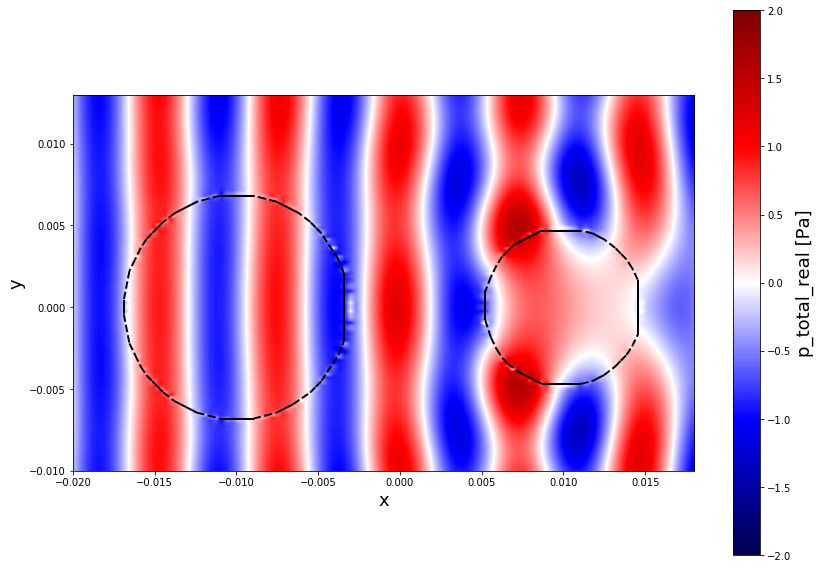

In [35]:
fig = plt.figure(figsize=(12, 8))
plt.imshow(np.real(postprocess_plane.total_field_imshow), 
           extent=postprocess_plane.bounding_box, 
           clim=(-2,2), 
           cmap='seismic', 
           interpolation='bilinear')

if len(postprocess_plane.domains_edges):
    for i, j in postprocess_plane.domains_edges:
        plt.plot(i, j, color = 'black', linestyle='dashed' ,linewidth=2)
        
plt.xlabel('x', size=18)
plt.ylabel('y', size=18)
cbar = plt.colorbar()
cbar.set_label("p_total_real [Pa]", size=18)
fig.tight_layout()
plt.show()

alternatively, you can use the plotting routins of OptimUS to visualise the 2D contour plots. The input arguments are an optimus PostProcessor object, type of the pressure field and pressure unit (Pa, kPa, MPa, GPa).

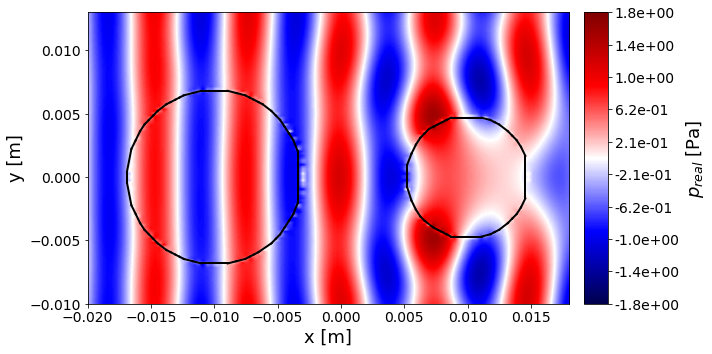

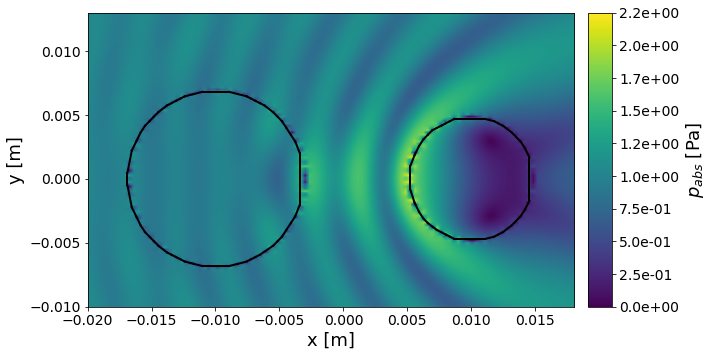

In [36]:
figs = optimus.postprocess.plot_pressure_field(postprocess_plane, field="total_pressure", unit='Pa')

Likewise, we can plot the scattered pressure field:

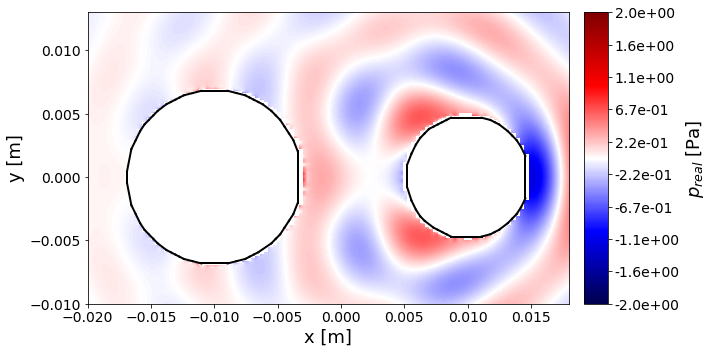

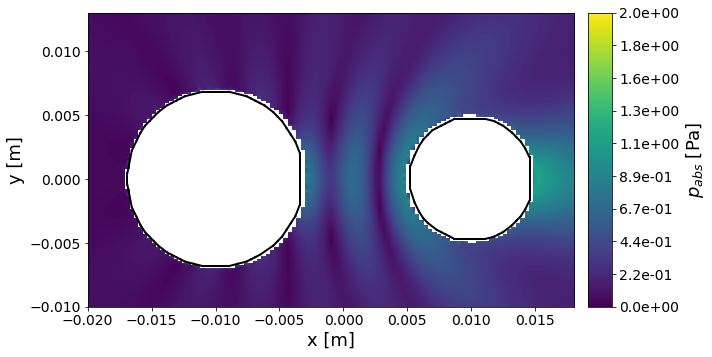

In [37]:
figs = optimus.postprocess.plot_pressure_field(postprocess_plane,field="scattered_pressure", unit='Pa', clim=(-2,2))

These figures can be saved (as a png, pdf, ps,...) files using savefig() method of a figure object, e.g. `figs[0].savefig('real_ptot.pdf')`.

#### 1.1. 2D plane visualisation - subdomains
So far, the plane cut through all subdomains, the visualisation code is generic though and we can compute the potentials anywhere in the space, inside and/or outside of each/all domains. Let's do an example where the visualisation plane is only around the LHS interface of subdomain 2 (the right sphere). 

In [19]:
postprocess_plane_subdomain = optimus.postprocess.VisualisePlane(model)

In [20]:
postprocess_plane_subdomain.create_computational_grid(resolution=[111,121], 
                                plane_axes=[0,1], 
                                plane_offset=0, 
                                bounding_box=[4e-3, 7e-3, -5e-3, 5e-3])

In [21]:
postprocess_plane_subdomain.compute_fields()

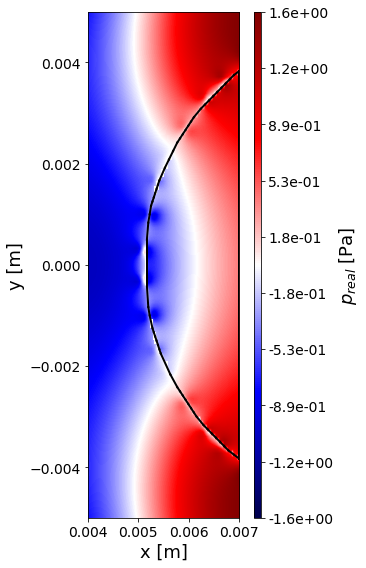

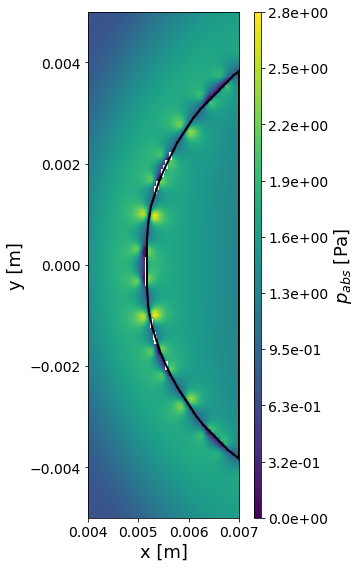

(<Figure size 720x576 with 2 Axes>, <Figure size 720x576 with 2 Axes>)

In [22]:
optimus.postprocess.plot_pressure_field(postprocess_plane_subdomain, field="total_pressure", unit='Pa')

This is a useful feature to achieve detailed presentation of a field across a small area with no need to increase resolution, hence computational costs.

### 2. User-defined points for visualisation
Let's create a postprocess object and define the 2D plane to determine the field. The input argument of the VisualiseCloudPoints object is the model object we created before. The points can be a 2D plane or a 3D cloud. Here, we will define a 2D structured plane to calculate the pressure fields in the volume. The visualisation grid can also be created in GMSH and imported here for field calculation.

In [23]:
postprocess_cloud = optimus.postprocess.VisualiseCloudPoints(model)

In [24]:
# Create a visualisation grid
Nx, Ny = 51, 51
xmin, xmax, ymin, ymax  = [-20e-3, 18e-3, -10e-3, 13e-3]
zval = 0.0
plot_grid = np.mgrid[xmin:xmax:Nx * 1j, ymin:ymax:Ny * 1j]
points = np.vstack((plot_grid[0].ravel(),
                    plot_grid[1].ravel(),
                    zval*np.ones(plot_grid[0].size)))

In [25]:
postprocess_cloud.create_computational_grid(points=points)

In [26]:
postprocess_cloud.compute_fields()

to display the fields using matplotlib imshow function, we need to reshape and correct the format of the pressure values using array_to_imshow function of optimus:

In [27]:
total_field_imshow = optimus.postprocess.common.array_to_imshow(
    postprocess_cloud.total_field.reshape((Nx,Ny)) )

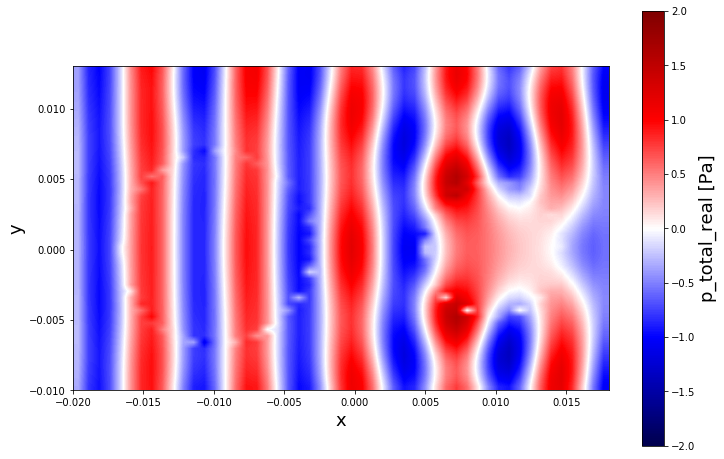

In [28]:
fig = plt.figure(figsize=(12, 8))
plt.imshow(np.real(total_field_imshow), 
           extent=[xmin, xmax, ymin, ymax], 
           clim=(-2,2), 
           cmap='seismic', 
           interpolation='bilinear')

plt.xlabel('x', size=18)
plt.ylabel('y', size=18)
cbar = plt.colorbar()
cbar.set_label("p_total_real [Pa]", size=18)
plt.show()

# Save/import a session
All the parameters, settings, BEM solutions and calculated fields can be saved as a database (db) file as follows: 

In [29]:
optimus.postprocess.export_to_file(model=model, 
                                   post_process=postprocess_plane, 
                                   global_parameters=optimus.global_parameters)

The data are written to the file: optimus_exported_data.db
The list of keys are: ['global_parameters', 'post_process', 'transducer_parameters', 'model', 'source']


the db files can be imported using the import_from_file function:

In [30]:
imported_db = optimus.postprocess.import_from_file('optimus_exported_data.db')

In [31]:
imported_db['global_parameters'].print()


Verbosity parameter: False

Linear algebra parameters:
 Linear solver: gmres
 Tolerance: 1e-05
 Maximum number of iterations: 1000
 Number of iterations before restart: 1000

Preconditioning parameters:
 OSRC preconditioner.
  Number of Padé expansion terms: 4
  Branch cut angle for Padé series: 1.0471975511965976
  Wavenumber: int
  Damped wavenumber: None

Postprocessing parameters:
 Potential operator assembly type is:  dense
 Solid angle tolerance is:  0.01
 Concave Hull threshold parameter (alpha) is:  0.1


*it should be noted that scipy operators (similarly optimus LHS/RHS continuous and discrete matrices/vectors are not pickable, hence cannot be saved. Therefore for any re-run of the problem they will need to be calculated again.*